In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

import time
import timeit

C:\Users\aquat\AppData\Local\Temp\ipykernel_10296\321412031.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [3]:
# Loading Dataset

nonDemented_train = np.load('/CSE499/TrainTest/non_demented_train.npy')
nonDemented_test = np.load('/CSE499/TrainTest/non_demented_test.npy')

veryMildDemented_train = np.load('/CSE499/TrainTest/very_mild_demented_train.npy')
veryMildDemented_test = np.load('/CSE499/TrainTest/very_mild_demented_test.npy')

mildDemented_train = np.load('/CSE499/TrainTest/mild_demented_train.npy')
mildDemented_test = np.load('/CSE499/TrainTest/mild_demented_test.npy')

moderateDemented_train = np.load('/CSE499/TrainTest/moderate_demented_train.npy')
moderateDemented_test = np.load('/CSE499/TrainTest/moderate_demented_test.npy')

In [4]:
# Shape of our dataset
print(f'Non Demented Train: ',nonDemented_train.shape)
print(f'Very Mild Demented Train: ',veryMildDemented_train.shape)
print(f'Mild Demented Train: ',mildDemented_train.shape)
print(f'Moderate Demented Train: ',moderateDemented_train.shape)

print(f'Non Demented Test: ',nonDemented_test.shape)
print(f'Very Mild Demented Test: ',veryMildDemented_test.shape)
print(f'Mild Demented Test: ',mildDemented_test.shape)
print(f'Moderate Demented Test: ',moderateDemented_test.shape)

Non Demented Train:  (2560, 128, 128, 3)
Very Mild Demented Train:  (1792, 128, 128, 3)
Mild Demented Train:  (716, 128, 128, 3)
Moderate Demented Train:  (51, 128, 128, 3)
Non Demented Test:  (640, 128, 128, 3)
Very Mild Demented Test:  (448, 128, 128, 3)
Mild Demented Test:  (180, 128, 128, 3)
Moderate Demented Test:  (13, 128, 128, 3)


In [5]:
from sklearn.utils import shuffle

# Assuming you have loaded and split your data into X_train, Y_train, X_test, and Y_test

# Initialize empty lists to hold data and labels
data_train = []
labels_train = []
data_test = []
labels_test = []

# For the "Non_Demented" class
data_train.extend(nonDemented_train)
labels_train.extend([0] * len(nonDemented_train))
data_test.extend(nonDemented_test)
labels_test.extend([0] * len(nonDemented_test))

# For the "Very_Mild_Demented" class
data_train.extend(veryMildDemented_train)
labels_train.extend([1] * len(veryMildDemented_train))
data_test.extend(veryMildDemented_test)
labels_test.extend([1] * len(veryMildDemented_test))

# For the "Mild_Demented" class
data_train.extend(mildDemented_train)
labels_train.extend([2] * len(mildDemented_train))
data_test.extend(mildDemented_test)
labels_test.extend([2] * len(mildDemented_test))

# For the "Moderate_Demented" class
data_train.extend(moderateDemented_train)
labels_train.extend([3] * len(moderateDemented_train))
data_test.extend(moderateDemented_test)
labels_test.extend([3] * len(moderateDemented_test))

# Convert lists to NumPy arrays
X_train = np.array(data_train)
Y_train = np.array(labels_train)
X_test = np.array(data_test)
Y_test = np.array(labels_test)

# Shuffle the data and labels
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

# Convert labels to one-hot encoded format
Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)


In [6]:
print(f'X train shape:',X_train.shape)
print(f'X test shape:',X_test.shape)
print(f'Y train shape:',Y_train.shape)
print(f'Y test shape:',Y_test.shape)

X train shape: (5119, 128, 128, 3)
X test shape: (1281, 128, 128, 3)
Y train shape: (5119, 4)
Y test shape: (1281, 4)


In [7]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

In [8]:
print(f'x train shape:',x_train.shape)
print(f'x val shape:',x_val.shape)
print(f'y train shape:',y_train.shape)
print(f'y val shape:',y_val.shape)

x train shape: (4095, 128, 128, 3)
x val shape: (1024, 128, 128, 3)
y train shape: (4095, 4)
y val shape: (1024, 4)


In [9]:
# Teacher model with ResNet50

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax'))  # Adjusted for 4 classes
    
    model.compile(
        loss='categorical_crossentropy',  # Adjusted for multi-class classification
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    return model

# Load ResNet50 with weights pre-trained on ImageNet
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# Call the model with the modified settings
model = build_model(resnet, lr=1e-4,)
model.build((None, 128, 128, 3))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,604,100
Trainable params: 23,546,884
No

In [10]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,verbose=1,factor=0.2, min_lr=1e-4)
filepath="ResNet50weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [11]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
# Configuration
import time
epochs = 7 
batch_size = 64

# Calculate the starting time    
start_time = time.time()

teacher_his = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=[learn_control, checkpoint])


end_time = time.time()
print("--- Time taken to train : %s seconds ---" % ((end_time - start_time)))

Epoch 1/7
64/64 [==============================] - 358s 5s/step - loss: 1.3104 - accuracy: 0.5260 - val_loss: 2.0694 - val_accuracy: 0.3818 - lr: 1.0000e-04
Epoch 2/7
64/64 [==============================] - 344s 5s/step - loss: 0.3971 - accuracy: 0.8657 - val_loss: 2.4400 - val_accuracy: 0.4844 - lr: 1.0000e-04
Epoch 3/7
64/64 [==============================] - 342s 5s/step - loss: 0.1295 - accuracy: 0.9617 - val_loss: 1.7274 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 4/7
64/64 [==============================] - 340s 5s/step - loss: 0.0483 - accuracy: 0.9861 - val_loss: 1.3039 - val_accuracy: 0.6885 - lr: 1.0000e-04
Epoch 5/7
64/64 [==============================] - 340s 5s/step - loss: 0.0579 - accuracy: 0.9827 - val_loss: 1.2287 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 6/7
64/64 [==============================] - 342s 5s/step - loss: 0.0411 - accuracy: 0.9883 - val_loss: 0.7917 - val_accuracy: 0.7480 - lr: 1.0000e-04
Epoch 7/7
64/64 [==============================] - 338s 5s

In [12]:
model.save_weights("ResNet50_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!


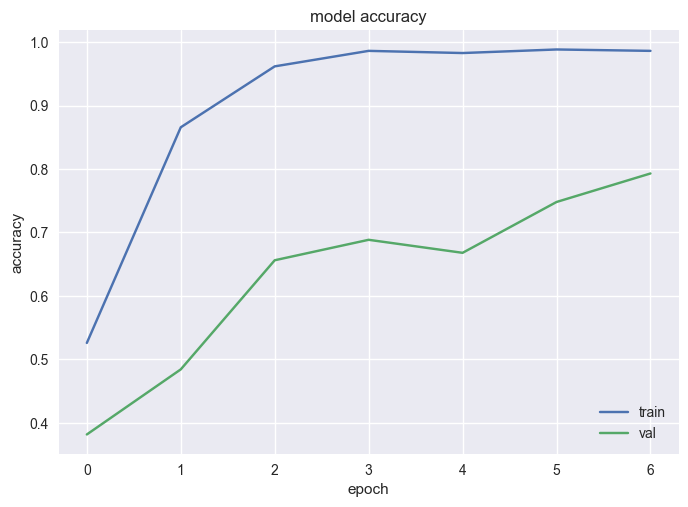

In [13]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

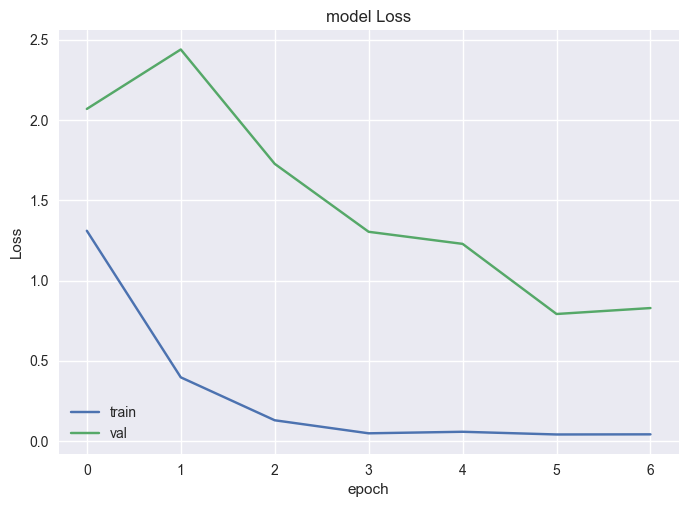

In [14]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [15]:
Y_val_pred = model.predict(x_val)
print('The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

32/32 [==============================] - 21s 605ms/step
The Teacher model Accuracy on the Validation Set: 0.79296875


In [16]:
#Checking my Y_test values
print('My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [17]:
#Checking predicted values from X_test dataset and calculating Y_pred with time
import timeit

start = timeit.default_timer()

y_pred = model.predict(X_test)
print('Predicted  Y_test values are: \n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ' ,stop - start, 'sec')

41/41 [==============================] - 25s 584ms/step
Predicted  Y_test values are: 
 [[3.7866484e-03 9.9356574e-01 1.7036643e-03 9.4394491e-04]
 [3.4830221e-03 8.9092898e-01 9.2937976e-02 1.2649974e-02]
 [6.0754089e-04 3.1670023e-02 9.6487713e-01 2.8453318e-03]
 ...
 [1.0786871e-07 1.4403388e-03 9.9804473e-01 5.1481073e-04]
 [2.3183270e-01 1.7399836e-01 5.4769206e-01 4.6476923e-02]
 [6.6875916e-10 3.8618010e-02 9.6082693e-01 5.5505737e-04]]

Time:  24.93761110000196 sec


In [18]:
start = timeit.default_timer()
#Checking the accuracy between the original and predicted (Y_test , y_pred)
print('Accuracy on Teacher model (ResNet50): ', accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis =1)))
stop = timeit.default_timer()
print('\nTime: ', stop - start, 'sec')

Accuracy on Teacher model (ResNet50):  0.7868852459016393

Time:  0.0009453000093344599 sec


In [19]:
# Classification_report
print('Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       640
           1       0.70      0.82      0.76       448
           2       0.73      0.53      0.62       180
           3       0.75      0.23      0.35        13

    accuracy                           0.79      1281
   macro avg       0.76      0.61      0.65      1281
weighted avg       0.79      0.79      0.78      1281



Auc Curve on Validation:



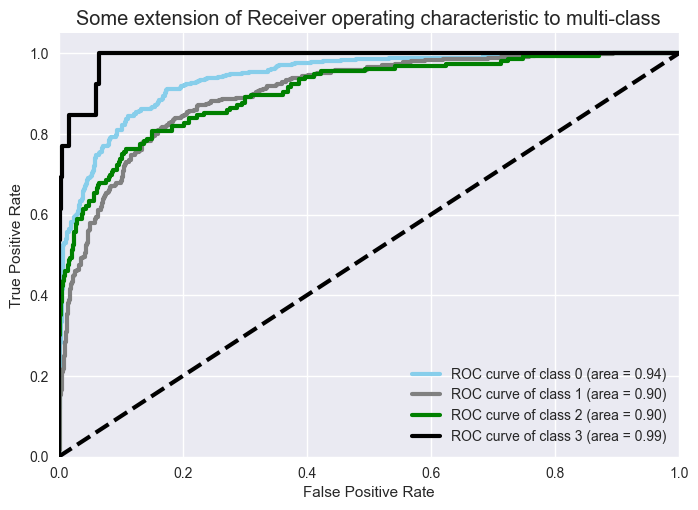

In [20]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print('Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], Y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), Y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['skyblue', 'grey', 'green', 'black'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



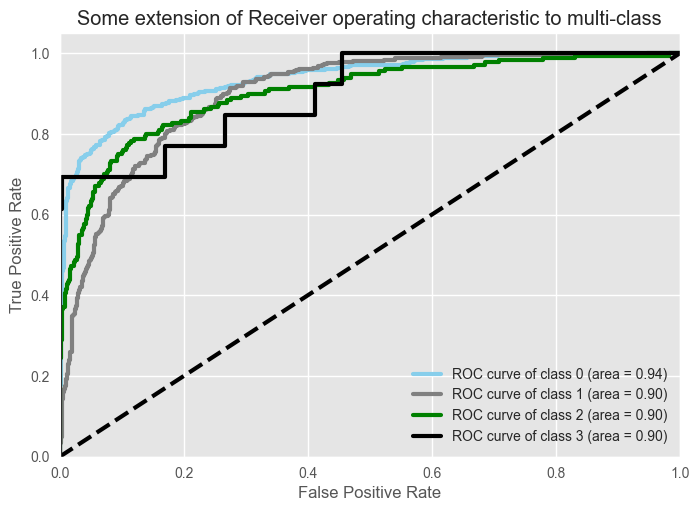

In [21]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['skyblue', 'grey', 'green', 'black'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Define the student model
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model
# Hyperparameters
input_shape = (128, 128, 3) # Input shape of each image
nb_classes = 4

customstudent = Sequential()
customstudent.add(Conv2D(128, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(64, (3, 3), activation='relu'))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(32, (3, 3), activation='relu'))
customstudent.add(Dropout(0.25)) # For reguralization

customstudent.add(layers.Flatten())

customstudent.add(layers.Dense(nb_classes))
customstudent.add(layers.Activation('softmax')) # Note that we add a normal softmax layer to begin with


customstudent.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(customstudent.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)       

In [23]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense').output)

In [24]:
# Define a manual softmax function
def softmax(x):
    x = np.exp(x - np.max(x))
    return np.exp(x)/(np.exp(x).sum())

In [25]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

32/32 [==============================] - 19s 603ms/step
(4095, 4)
(1024, 4)
(4095, 8)
(1024, 8)


In [26]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
temp = 10
customstudent.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = customstudent.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model 
customstudent = Model(customstudent.input, output)

customstudent.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 12  3584        ['conv2d_input[0][0]']           
                                8)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 128)  0           ['conv2d[0][0]']                 
                                                                                            

In [27]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

customstudent.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] 
  )

In [28]:
# Train the student model
epochs = 15
batch_size = 64
customstudent_student_his = customstudent.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/15
64/64 [==============================] - 100s 2s/step - loss: 0.1377 - acc: 0.3612 - val_loss: 0.1370 - val_acc: 0.3672
Epoch 2/15
64/64 [==============================] - 99s 2s/step - loss: 0.1312 - acc: 0.4271 - val_loss: 0.1286 - val_acc: 0.4678
Epoch 3/15
64/64 [==============================] - 99s 2s/step - loss: 0.1262 - acc: 0.4813 - val_loss: 0.1285 - val_acc: 0.4707
Epoch 4/15
64/64 [==============================] - 99s 2s/step - loss: 0.1254 - acc: 0.4906 - val_loss: 0.1285 - val_acc: 0.4707
Epoch 5/15
64/64 [==============================] - 98s 2s/step - loss: 0.1250 - acc: 0.4957 - val_loss: 0.1285 - val_acc: 0.4707
Epoch 6/15
64/64 [==============================] - 98s 2s/step - loss: 0.1241 - acc: 0.5055 - val_loss: 0.1285 - val_acc: 0.4707
Epoch 7/15
64/64 [==============================] - 98s 2s/step - loss: 0.1240 - acc: 0.5057 - val_loss: 0.1285 - val_acc: 0.4707
Epoch 8/15
64/64 [==============================] - 98s 2s/step - loss: 0.1238 - acc: 0.5

C:\Users\aquat\AppData\Local\Temp\ipykernel_10296\2520390268.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


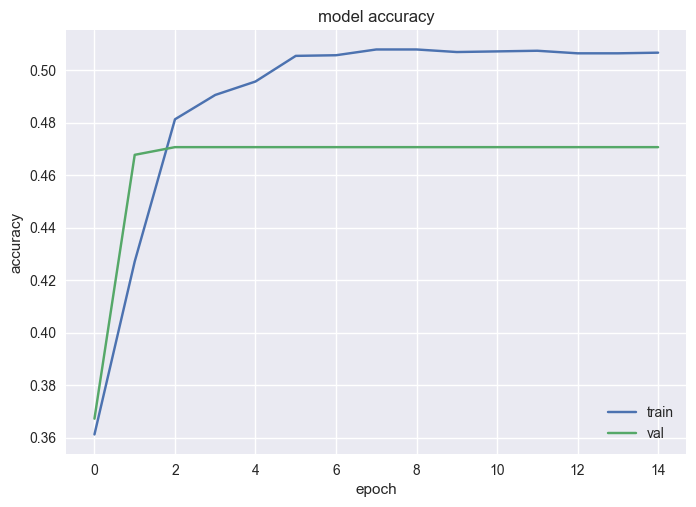

In [29]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.style.use('seaborn')
plt.plot(customstudent_student_his.history['acc'])
plt.plot(customstudent_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

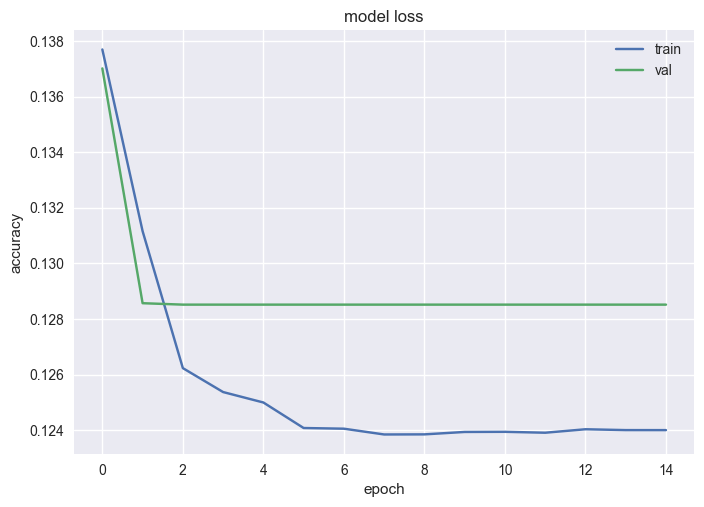

In [30]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(customstudent_student_his.history['loss'])
plt.plot(customstudent_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [31]:
Y_val_pred_student = customstudent.predict(x_val)
print(f'The CustomStudent model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred_student, axis=1)))

32/32 [==============================] - 6s 182ms/step
The CustomStudent model Accuracy on the Validation Set: 0.470703125


In [32]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [33]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred_student = customstudent.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred_student)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

41/41 [==============================] - 7s 179ms/step
My predicted Y_test values are:
 [[0.47536692 0.17487772 0.17487772 ... 0.24359521 0.24359521 0.24359521]
 [0.47536692 0.17487772 0.17487772 ... 0.24359521 0.24359521 0.24359521]
 [0.47536692 0.17487772 0.17487772 ... 0.24359521 0.24359521 0.24359521]
 ...
 [0.47536692 0.17487772 0.17487772 ... 0.24359521 0.24359521 0.24359521]
 [0.47536692 0.17487772 0.17487772 ... 0.24359521 0.24359521 0.24359521]
 [0.47536692 0.17487772 0.17487772 ... 0.24359521 0.24359521 0.24359521]]

Time:  7.474076599988621 sec


In [34]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Custom Student model on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Custom Student model on the Test set is: 0.4996096799375488

Time:  0.0012584000069182366 sec


In [35]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       640
           1       0.00      0.00      0.00       448
           2       0.00      0.00      0.00       180
           3       0.00      0.00      0.00        13

    accuracy                           0.50      1281
   macro avg       0.12      0.25      0.17      1281
weighted avg       0.25      0.50      0.33      1281



c:\Users\aquat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aquat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aquat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Auc Curve on Validation:



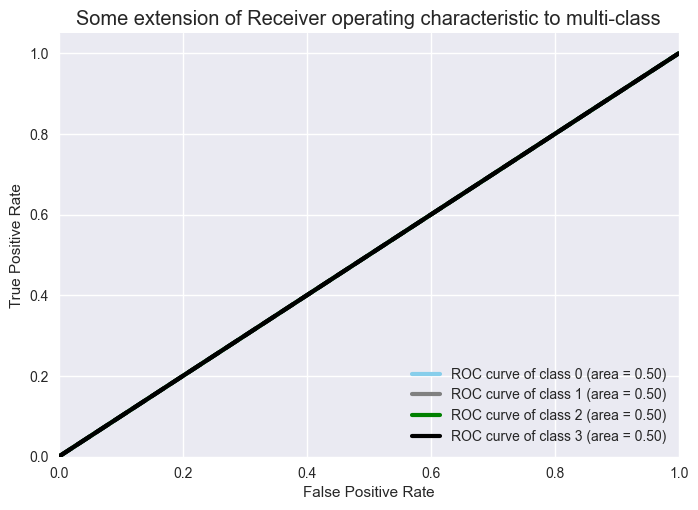

In [36]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], Y_val_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_new.ravel(), Y_val_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['skyblue', 'grey', 'green', 'black'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



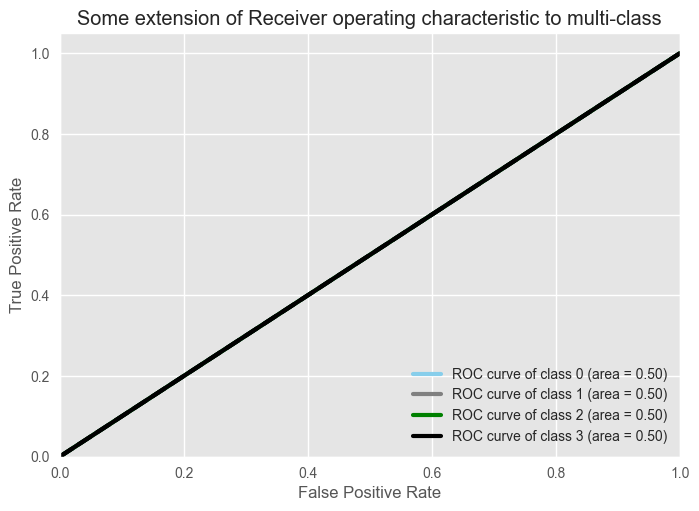

In [37]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['skyblue', 'grey', 'green', 'black'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()